In [1]:
from bs4 import BeautifulSoup
import bleach
import requests

# Wikipedia scraper from
# http://www.gyford.com/phil/writing/2015/03/25/wikipedia-parsing.php

class WikipediaFetcher(object):

    def fetch(self, page_name):
        """
        Passed a Wikipedia page's URL fragment, like
        'Edward_Montagu,_1st_Earl_of_Sandwich', this will fetch the page's
        main contents, tidy the HTML, strip out any elements we don't want
        and return the final HTML string.

        Returns a dict with two elements:
            'success' is either True or, if we couldn't fetch the page, False.
            'content' is the HTML if success==True, or else an error message.
        """
        result = self._get_html(page_name)
        
        if result['success']:
            result['content'] = self._tidy_html(result['content'])
            
        return result

    
    def _get_html(self, page_name):
        """
        Passed the name of a Wikipedia page (eg, 'Samuel_Pepys'), it fetches
        the HTML content (not the entire HTML page) and returns it.

        Returns a dict with two elements:
            'success' is either True or, if we couldn't fetch the page, False.
            'content' is the HTML if success==True, or else an error message.
        """
        error_message = ''

        url = 'https://en.wikipedia.org/wiki/%s' % page_name

        try:
            response = requests.get(url, params={'action':'render'}, timeout=5)
        except requests.exceptions.ConnectionError as e:
            error_message = "Can't connect to domain."
        except requests.exceptions.Timeout as e:
            error_message = "Connection timed out."
        except requests.exceptions.TooManyRedirects as e:
            error_message = "Too many redirects."

        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            # 4xx or 5xx errors:
            error_message = "HTTP Error: %s" % response.status_code
        except NameError:
            if error_message == '':
                error_message = "Something unusual went wrong."

        if error_message:
            return {'success': False, 'content': error_message} 
        else:
            return {'success': True, 'content': response.text}

    def _tidy_html(self, html):
        """
        Passed the raw Wikipedia HTML, this returns valid HTML, with all
        disallowed elements stripped out.
        """
        #html = self._bleach_html(html)
        #html = self._strip_html(html)
        return html

    def _bleach_html(self, html):
        """
        Ensures we have valid HTML; no unclosed or mis-nested tags.
        Removes any tags and attributes we don't want to let through.
        Doesn't remove the contents of any disallowed tags.

        Pass it an HTML string, it'll return the bleached HTML string.
        """

        # Pretty much most elements, but no forms or audio/video.
        allowed_tags = [
            'a', 'abbr', 'acronym', 'address', 'area', 'article',
            'b', 'blockquote', 'br',
            'caption', 'cite', 'code', 'col', 'colgroup',
            'dd', 'del', 'dfn', 'div', 'dl', 'dt',
            'em',
            'figcaption', 'figure', 'footer',
            'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'header', 'hgroup', 'hr',
            'i', 'img', 'ins',
            'kbd',
            'li',
            'map',
            'nav',
            'ol',
            'p', 'pre',
            'q',
            's', 'samp', 'section', 'small', 'span', 'strong', 'sub', 'sup',
            'table', 'tbody', 'td', 'tfoot', 'th', 'thead', 'time', 'tr',
            'ul',
            'var',
        ]

        # These attributes will be removed from any of the allowed tags.
        allowed_attributes = {
            '*':        ['class', 'id'],
            'a':        ['href', 'title'],
            'abbr':     ['title'],
            'acronym':  ['title'],
            'img':      ['alt', 'src', 'srcset'],
            # Ugh. Don't know why this page doesn't use .tright like others
            # http://127.0.0.1:8000/encyclopedia/5040/
            'table':    ['align'],
            'td':       ['colspan', 'rowspan'],
            'th':       ['colspan', 'rowspan', 'scope'],
        }

        return bleach.clean(html, tags=allowed_tags,
                                    attributes=allowed_attributes, strip=True)

    def _strip_html(self, html):
        """
        Takes out any tags, and their contents, that we don't want at all.
        And adds custom classes to existing tags (so we can apply CSS styles
        without having to multiply our CSS).

        Pass it an HTML string, it returns the stripped HTML string.
        """

        # CSS selectors. Strip these and their contents.
        selectors = [
            'div.hatnote',
            'div.navbar.mini', # Will also match div.mini.navbar
            # Bottom of https://en.wikipedia.org/wiki/Charles_II_of_England :
            'div.topicon',
            'a.mw-headline-anchor',
        ]

        # Strip any element that has one of these classes.
        classes = [
            # "This article may be expanded with text translated from..."
            # https://en.wikipedia.org/wiki/Afonso_VI_of_Portugal
            'ambox-notice',
            'magnify',
            # eg audio on https://en.wikipedia.org/wiki/Bagpipes
            'mediaContainer',
            'navbox',
            'noprint',
        ]

        # Any element has a class matching a key, it will have the classes
        # in the value added.
        add_classes = {
            # Give these tables standard Bootstrap styles.
            'infobox':   ['table', 'table-bordered'],
            'ambox':     ['table', 'table-bordered'],
            'wikitable': ['table', 'table-bordered'],
        } 

        soup = BeautifulSoup(html)

        for selector in selectors:
            [tag.decompose() for tag in soup.select(selector)]

        for clss in classes:
            [tag.decompose() for tag in soup.find_all(attrs={'class':clss})]

        for clss, new_classes in add_classes.iteritems():
            for tag in soup.find_all(attrs={'class':clss}):
                tag['class'] = tag.get('class', []) + new_classes

        # Depending on the HTML parser BeautifulSoup used, soup may have
        # surrounding <html><body></body></html> or just <body></body> tags.
        if soup.body:
            soup = soup.body
        elif soup.html:
            soup = soup.html.body

        # Put the content back into a string.
        html = ''.join(str(tag) for tag in soup.contents)

        return html

In [2]:
# List of articles to scrape based on AI techniques
# Extracted from my browsing history in Fall 2015

article_list = ["Bayesian network",
    "Elastic map",
    "Mixture model",
    "Statistical inference",
    "Probability_interpretations",
    "Unsupervised_learning",
    "Learning_to_rank",
    "Grammar_induction",
    "Semi-supervised_learning",
    "Online_machine_learning",
    "Feature_engineering",
    "Feature_learning",
    "Structured_prediction",
    "Reinforcement_learning",
    "Anomaly_detection",
    "Association_rule_learning",
    "Regression_analysis",
    "Statistical_classification",
    "Bayesian_inference",
    "Sufficient statistic",
    "Variational Bayesian methods",
    "Artificial intelligence",
    "Binary Independence Model",
    "Bootstrapping_(statistics)",
    "Cluster analysis",
    "Cosine similarity",
    "Cross-validation_(statistics)",
    "Cross entropy",
    "Data compression",
    "Data science",
    "Decision tree learning",
    "Ensemble learning",
    "Entropy_(information_theory)",
    "Feedforward neural network",
    "Gradient boosting",
    "Information retrieval",
    "Information theory",
    "Kernel method",
    "Kullback Leibler divergence",
    "Lasso (statistics)",
    "Latent Dirichlet allocation",
    "Latent semantic analysis",
    "Likelihood function",
    "Logistic regression",
    "Loss function",
    "Loss functions for classification",
    "Machine learning",
    "Multidimensional scaling",
    "Naive Bayes classifier",
    "Supervised_learning",
    "Bootstrap_aggregating",
    "K-nearest_neighbors_algorithm",
    "Linear_regression",
    "Artificial_neural_network",
    "Perceptron",
    "Support_vector_machine",
    "K-means_clustering",
    "Linear_discriminant_analysis",
    "Non-negative_matrix_factorization",
    "Local_outlier_factor",
    "Autoencoder",
    "Deep_learning",
    "Multilayer_perceptron",
    "Recurrent_neural_network",
    "Restricted_Boltzmann_machine",
    "Convolutional neural network",
    "Bias–variance_tradeoff",
    "Nonlinear dimensionality reduction",
    "Overfitting",
    "PageRank",
    "Precision and recall",
    "Principal component analysis",
    "Random forest",
    "Receiver operating characteristic",
    "Self information",
    "Self organizing map",
    "Sentiment analysis",
    "Simulated annealing",
    "Singular value decomposition",
    "Skewness",
    "Softmax function",
    "Stochastic gradient descent",
    "Tf–idf",
    "Topic model",
    "Sensitivity_and_specificity",
    "Web search engine",
    "Web search query",
    "n-gram"
]

In [3]:
document_set = {}

# Scrape each article
for article in article_list:
    myScraper = WikipediaFetcher()
    scraped_article = myScraper.fetch(page_name=article)
    
    # If succesfully scraped
    if scraped_article['success'] == True:
        
        # Use beautiful soup to parse HTML
        soup = BeautifulSoup(scraped_article['content'], 'html.parser')
        
        # FInd all p tags which seem to contain the body of the articles
        get_tags = soup.find_all(['p'])        
        
        document_text = ""        
        # For each tag found, strip extra characters and append to a document text string
        for tag in get_tags:    
            document_text = document_text + " " + (''.join(tag.findAll(text=True))).strip()                
        
        # If the document is of sufficient size
        if len(document_text) > 2500:                
            document_set[article]  = document_text
        else:
            print "----------------------------------------------------------------"
            print article + " -- was too short: "
            print ""
            print document_text
            print "----------------------------------------------------------------"
            print ""
            
    else:
            print "----------------------------------------------------------------"
            print article + " -- failed to scrape"
            print "----------------------------------------------------------------"
            print ""

In [4]:
import collections
from random import shuffle

dataset = document_set.values()

# Check for and remove duplicates 
dupes = [item for item, count in collections.Counter(dataset).items() if count > 1]

# Shuffle order for model training
if len(dupes) > 0:
    print "Duplicates found..."
    print dupes
    print ""
    dataset = list(set(dataset))
    shuffle(dataset)
else:
    shuffle(dataset)

In [ ]:
### Tokenizer For Clustering ###

import nltk
import re

# Porter stemmer is a pre-trained stemmer that finds the most likely stem for an english word
from gensim.parsing import PorterStemmer
global_stemmer = PorterStemmer()

# Make a helper that will return the original form of the stem in future methods
class StemmingHelper(object):
    """
    Class to aid the stemming process - from word to stemmed form,
    and vice versa.
    The 'original' form of a stemmed word will be returned as the
    form in which its been used the most number of times in the text.
    """
 
    #This reverse lookup will remember the original forms of the stemmed words
    word_lookup = {}
 
    @classmethod
    def stem(cls, word):
        """
        Stems a word and updates the reverse lookup.
        """
 
        #Stem the word
        stemmed = global_stemmer.stem(word)
 
        #Update the word lookup
        if stemmed not in cls.word_lookup:
            cls.word_lookup[stemmed] = {}
        cls.word_lookup[stemmed][word] = (
            cls.word_lookup[stemmed].get(word, 0) + 1)
 
        return stemmed
 
    @classmethod
    def original_form(cls, word):
        """
        Returns original form of a word given the stemmed version,
        as stored in the word lookup.
        """
 
        if word in cls.word_lookup:
            return max(cls.word_lookup[word].keys(),
                       key=lambda x: cls.word_lookup[word][x])
        else:
            return word


# NLTK stopwords to remove (in addition to the scikit-learn default)
from nltk.corpus import stopwords
myStop = stopwords.words('english')

# Remove unicode, normalizing it to ascii
import unicodedata

# Custom tokenizer
class tokenize_custom(object):
    def __call__(self, doc):
        # Clean the document by normalizing to ascii
        doc = unicodedata.normalize('NFKD', doc).encode('ascii','ignore')        
        # Remove hyphens and dashes
        doc = re.sub('[-—]', ' ', doc)

        # First tokenize by sentence then by word
        tokens = [word for sent in nltk.sent_tokenize(doc) for word in nltk.word_tokenize(sent)]
        
        filtered_tokens = []
        # Filter out any tokens not containing at least 2 letters or in the stop word list
        for token in tokens:
            if len(re.sub('[^a-zA-Z]', '', token)) > 2 and word not in myStop:                       
                # Stem the token
                filtered_tokens.append(StemmingHelper.stem(token))      
                
        return filtered_tokens

In [ ]:
# Based off of scikit-learn clustering tutorial: 
# http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
    
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #" + str(topic_idx + 1) + ": ")
        # Return features in their original form
        print(" ".join([StemmingHelper.original_form(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
### LDA ###

n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, tokenizer = tokenize_custom(), stop_words = 'english')
t0 = time()
tf = tf_vectorizer.fit_transform(dataset)
print("Vectorizing done in %0.3fs." % (time() - t0))

lda = LatentDirichletAllocation(n_topics = n_topics, max_iter=300)
print("Fitting LDA")
t0 = time()
lda.fit(tf)
print("Fitting done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
print ("")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
### NMF ###

n_topics = 10
n_top_words = 10

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, tokenizer = tokenize_custom(), stop_words = 'english')
print("Extracting tf-idf features for NMF...")
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))

nmf = NMF(n_components=n_topics, alpha=.05, l1_ratio=.5).fit(tfidf)
# Fit the NMF model
print("Fitting NMF")
t0 = time()
exit()
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


#  Modify tf-idf with sublinear evaluation
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, max_df=0.8, min_df=5, tokenizer = tokenize_custom(), stop_words = 'english')
print("Extracting tf-idf features for NMF...")
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))

nmf = NMF(n_components=n_topics, alpha=.05, l1_ratio=.5).fit(tfidf)
# Fit the NMF model
print("Fitting NMF")
t0 = time()
exit()
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

In [5]:
### word2Vec data pre-processing ###

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.models import Word2Vec
from gensim.parsing import PorterStemmer
global_stemmer = PorterStemmer()

import nltk
import re

# Stopwords to remove
from nltk.corpus import stopwords
myStop = stopwords.words('english')

class StemmingHelper(object):
    """
    Class to aid the stemming process - from word to stemmed form,
    and vice versa.
    The 'original' form of a stemmed word will be returned as the
    form in which its been used the most number of times in the text.
    """
 
    #This reverse lookup will remember the original forms of the stemmed
    #words
    word_lookup = {}
 
    @classmethod
    def stem(cls, word):
        """
        Stems a word and updates the reverse lookup.
        """
 
        #Stem the word
        stemmed = global_stemmer.stem(word)
 
        #Update the word lookup
        if stemmed not in cls.word_lookup:
            cls.word_lookup[stemmed] = {}
        cls.word_lookup[stemmed][word] = (
            cls.word_lookup[stemmed].get(word, 0) + 1)
 
        return stemmed
 
    @classmethod
    def original_form(cls, word):
        """
        Returns original form of a word given the stemmed version,
        as stored in the word lookup.
        """
 
        if word in cls.word_lookup:
            returnMe = max(cls.word_lookup[word].keys(),
                       key=lambda x: cls.word_lookup[word][x])
            return returnMe[:10]
        else:
            return word[:10]
        
# Clean unicode
import unicodedata
    
# Custom tokenizer which produces sentence-wise tokens
def sentence_tokenize(doc):
        doc = unicodedata.normalize('NFKD', doc).encode('ascii','ignore')
        
        doc = re.sub('[-—]', ' ', doc)
        
        sentences = nltk.sent_tokenize(doc) 
        
        sentence_token_list = []
        for sentence in sentences:
            # Filter sentences with less than 5 words
            if len(sentence) > 4:                
                sentence_token_list.append([
                        StemmingHelper.stem(word) 
                        for word in nltk.word_tokenize(sentence)
                        # Filter words without two letters
                        if len(re.sub('[^a-zA-Z]', '', word)) > 2
                    ])       

        return sentence_token_list

# Build massive list of  sentences that are tokenized
corpus = []
for text in dataset:
         corpus.extend(sentence_tokenize(text))

In [63]:
model = Word2Vec(corpus, 
                 # Down sample words that appear 1 in 1000 tokens
                 sample = (1/1000), 
                 # Remove words that do not occur at least 4 times
                 min_count=4, 
                 # Use 64 available cores
                 workers= 64, 
                 # Iterate 1000 times over the dataset
                 iter = 1000, 
                 # Size ~ number of topics ... to be experimented with
                 # Sqrt(vocab length) is sometimes recommended but likely for larger datasets
                 size = 60)

vocab = list(model.vocab.keys())
print len(vocab)

# Test similarities for common words
test = "data science machine learning precision"

for stem in (StemmingHelper.stem(word) for word in test.split()):
    print "Similar to: " + StemmingHelper.original_form(stem)
    for similar in model.most_similar(stem)[0:5]:
        print StemmingHelper.original_form(similar[0])
    print "--------------"
    
print ""

2571
Similar to: data
unlabeled
dataset
set
points
training
--------------
Similar to: science
cognitive
psychology
field
discipline
computer
--------------
Similar to: machine
learning
supervised
unsupervis
support
psychology
--------------
Similar to: learning
supervised
unsupervis
reinforcem
deep
machine
--------------
Similar to: precision
recall
harmonic
Markedness
inverse
Matthews
--------------



In [7]:
# Attempt k-means clustering on model
from time import time 
from sklearn.cluster import KMeans

k = 8

km = KMeans(n_clusters =  k, n_jobs =64)
           
print("Clustering data with %s" % km)
t0 = time()
km.fit(model.syn0)
print("done in %0.3fs" % (time() - t0))
print()

Clustering data with KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=64, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
done in 1.106s
()


In [8]:
print("Top terms per cluster:")

word_indices = model.index2word
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(0, k):
    print("Cluster " + str(i+1)) + ": "
    cluster_features = []
    for index in order_centroids[i]:
        if len(word_indices[index]) > 3:
            cluster_features.append(StemmingHelper.original_form(word_indices[index]))
    print ' '.join(cluster_features[:10])
    print "----------------------------------------------"
    print ""

Top terms per cluster:
Cluster 1: 
example general other based informatio with probabilit statistica number where
----------------------------------------------

Cluster 2: 
with mean distributi problem these estimate points linear vector based
----------------------------------------------

Cluster 3: 
mean example these other informatio machine been some then general
----------------------------------------------

Cluster 4: 
methods different statistica training network been mean number from each
----------------------------------------------

Cluster 5: 
distributi statistica given data value learning variables different features problem
----------------------------------------------

Cluster 6: 
these general more probabilit other algorithm example sample some prediction
----------------------------------------------

Cluster 7: 
example number problem mean other have probabilit case function model
----------------------------------------------

Cluster 8: 
these mean only number 

In [ ]:
# Multi-gram model

from gensim.models import Phrases

bigram_transformer = Phrases(corpus)
phrase_model = Word2Vec(bigram_transformer[corpus], 
                 # Down sample words that appear 1 in 250 tokens to allow bigrams to surface
                 sample = (1/250), 
                 # Remove words that do not occur at least 4 times in case some rare bigrams are important
                 min_count=4, 
                 # Use 64 available cores
                 workers= 64, 
                 # Iterate 500 times over the dataset to improve accuracy
                 iter = 500, 
                 # Default size
                 size = 100)

phrase_vocab = list(phrase_model.vocab.keys())
len(phrase_vocab)

In [ ]:
from time import time 
from sklearn.cluster import KMeans

k = 8

km_phrase = KMeans(n_clusters =  k, n_jobs =64)
           
print("Clustering data with %s" % km_phrase)
t0 = time()
km_phrase.fit(phrase_model.syn0)
print("done in %0.3fs" % (time() - t0))
print()

In [ ]:
print("Top terms per cluster:")

word_indices = phrase_model.index2word
order_centroids = km_phrase.cluster_centers_.argsort()[:, ::-1]

for i in range(0, k):
    print("Cluster " + str(i+1)) + ": "
    cluster_features = []
    for index in order_centroids[i]:
        if len(word_indices[index]) > 3:
            cluster_features.append(StemmingHelper.original_form(word_indices[index]))
    print ' '.join(cluster_features[:10])
    print "----------------------------------------------"
    print ""

In [72]:
# Mind-map

def _get_param_matrices(vocabulary, sentence_terms):
    """
    Returns
    1. Top 2500 (or less, if vocab is short) most frequent terms as a list
    2. Co-occurence matrix for these terms as a dictionary
    3. Dictionary containing Pg (expected probability) of most-frequent terms
    4. Number of terms affected of each term as a dictionary
    """
 
    #Figure out top n terms with respect to mere occurences
    n = min(2500, len(vocabulary))
    topterms = list(vocabulary.keys())
    topterms.sort(key = lambda x: vocabulary[x], reverse = True)
    topterms = topterms[:n]
 
    #nw maps term to the number of terms it 'affects'
    #(sum of number of terms in all sentences it
    #appears in)
    nw = {}
    #Co-occurence values are wrt top terms only
    co_occur = {}
    #Initially, co-occurence matrix is empty
    for x in vocabulary:
        co_occur[x] = [0 for i in range(len(topterms))]
 
    #Iterate over list of all sentences' vocabulary dictionaries
    #Build the co-occurence matrix
    for sentence in sentence_terms:
        total_terms = sum(list(sentence.values()))
        #This list contains the indices of all terms from topterms,
        #that are present in this sentence
        top_indices = []
        #Populate top_indices
        top_indices = [topterms.index(x) for x in sentence
                       if x in topterms]
        #Update nw dict, and co-occurence matrix
        for term in sentence:
            nw[term] = nw.get(term, 0) + total_terms
            for index in top_indices:
                co_occur[term][index] += (sentence[term] *
                                          sentence[topterms[index]])
 
    #Pg is just nw[term]/total vocabulary of text
    Pg = {}
    N = sum(list(vocabulary.values()))
    for x in topterms:
        Pg[x] = float(nw[x])/N
 
    return topterms, co_occur, Pg, nw

def get_top_n_terms(vocabulary, sentence_terms, n):
    """
    Returns the top 'n' terms from a block of text, in the form of a list,
    from most important to least.
 
    'vocabulary' should be a dict mapping each term to the number
    of its occurences in the entire text.
    'sentence_terms' should be an iterable of dicts, each denoting the
    vocabulary of the corresponding sentence.
    """
 
    #First compute the matrices
    topterms, co_occur, Pg, nw = _get_param_matrices(vocabulary,
                                                     sentence_terms)
 
    #This dict will map each term to its weightage with respect to the
    #document
    result = {}
 
    N = sum(list(vocabulary.values()))
    #Iterates over all terms in vocabulary
    for term in co_occur:
        term = str(term)
        org_term = str(term)
        for x in Pg:
            #expected_cooccur is the expected cooccurence of term with this
            #term, based on nw value of this and Pg value of the other
            expected_cooccur = nw[term] * Pg[x]
            #Result measures the difference(in no of terms) of expected
            #cooccurence and  actual cooccurence
            result[org_term] = ((co_occur[term][topterms.index(x)] -
                                 expected_cooccur)**2/ float(expected_cooccur))
 
    terms = list(result.keys())
    terms.sort(key=lambda x: result[x],
               reverse=True)
 
    return terms[:n]

In [69]:
# Count all words across sentences and co-occurences within sentences to select top terms

full_vocab_count = {}

full_word= []
for sentence in corpus:
    full_word.extend(sentence)

from collections import Counter
full_vocab_count = Counter(full_word)

sentence_vocab_count_list = []
for sentence in corpus:
    sentence_vocab_count_list.append(Counter(sentence)) 

In [73]:
top_terms = get_top_n_terms(full_vocab_count, sentence_vocab_count_list, n = 750)

In [132]:
# Filter manually identified common words (in the top 1000) from the set
common_words = "minimum threshold norm singular bootstrap semi constant context input output spatial step bound error row bilinear manifold posterior prior algorithm similar index search web rank page predictor least rate standard joint event group class gain target set pair state higher lower good non zero normal subject log Convex proportion ratio margin random experiment pre effect assess style list user domain level high complex explain factor sum basic special contrast local dataset equal shift correct control true agent risk cost difficult central coin human power went avoid order low Act Causual Logic Chosen Fall Main Whole Hard Version Adjust Led Seen Whose Statement Across Game Fast Aim Done Via Thought Manner Fashion Final Last Third Temperature Fewer Affect Begin Deal Return Turn Free Scheme Attempt Robot World Distinct Start Sub Etc Formal Taken Kind Place Account Help Back Per Length End Pass Along Move Store Greater Larger Smaller Total Size Drawn Next Full Appear Major Address Think Want Get Know Understand Whether Question Answer Write Form Formula Law Four Except Hold Side Hand Left Right Almost Near Tool Around Million Lack Reflect Try Proof Enough Unseen Yield Tend Book Later Though Beyond Upon Notion Far Longer Still Better Less Actual Long Short Action Goal Problem Respect Much Process Given System Analysis Large Small Real Limit Found Right Name Second Look Within Reason Above Addition Also Although Among Amount Another Approach Are Based Because Called Case Certain Close Come Common Concept Considered Correspond  Could Current Does Due Either Even Example Fact Field Find First Following Gives Has However Idea Include Instead Interest Known Lead Like Made Make Many May Might Must New Number Often Paper Part Particular Popular Previous Product Rather Recent Required Research See Shown Since Success Takes Theorem They This Three Thus Time Two Type Used Usually Value Was Well Without Work Would Written"

common_words = [word.lower() for word in common_words.split()]

refined_top_terms = [term for term in top_terms 
                     if 
                        # Some words that are highly common do not converge (are not found in the vocab)
                        StemmingHelper.original_form(term) in vocab 
                     
                        # Remove stop words or common words
                        # Avoid any possible overlap in the stems as well
                        and StemmingHelper.original_form(term) not in myStop 
                        and StemmingHelper.original_form(term) not in common_words 
                        and term not in myStop 
                        and term not in common_words]

print len(refined_top_terms)

56


In [56]:
from scipy.spatial.distance import cosine
from networkx import Graph
 
def build_mind_map(model, stemmer, root, nodes, alpha):
    """
    Returns the Mind-Map in the form of a NetworkX Graph instance.
 
    'model' should be an instance of gensim.models.Word2Vec
    'nodes' should be a list of terms, included in the vocabulary of
    'model'.
    'root' should be the node that is to be used as the root of the Mind
    Map graph.
    'stemmer' should be an instance of StemmingHelper.
    """
 
    #This will be the Mind-Map
    g = Graph()
 
    #Ensure that the every node is in the vocabulary of the Word2Vec
    #model, and that the root itself is included in the given nodes
    for node in nodes:
        if node not in model.vocab:
            raise ValueError(node + " not in model's vocabulary")
    if root not in nodes:
        raise ValueError("root not in nodes")
 
    ##Containers for algorithm run
    #Initially, all nodes are unvisited
    unvisited_nodes = set(nodes)
    #Initially, no nodes are visited
    visited_nodes = set([])
    #The following will map visited node to its contextual vector
    visited_node_vectors = {}
    #Thw following will map unvisited nodes to (closest_distance, parent)
    #parent will obviously be a visited node
    node_distances = {}
 
    #Initialization with respect to root
    current_node = root
    visited_node_vectors[root] = model[root]
    unvisited_nodes.remove(root)
    visited_nodes.add(root)
 
    #Build the Mind-Map in n-1 iterations
    for i in range(1, len(nodes)):
        #For every unvisited node 'x'
        for x in unvisited_nodes:
            #Compute contextual distance between current node and x
            dist_from_current = cosine(visited_node_vectors[current_node],
                                       model[x])
            #Get the least contextual distance to x found until now
            distance = node_distances.get(x, (100, ''))
            #If current node provides a shorter path to x, update x's
            #distance and parent information
            if distance[0] > dist_from_current:
                node_distances[x] = (dist_from_current, current_node)
 
        #Choose next 'current' as that unvisited node, which has the
        #lowest contextual distance from any of the visited nodes
        next_node = min(unvisited_nodes,
                        key=lambda x: node_distances[x][0])
 
        ##Update all containers
        parent = node_distances[next_node][1]
        del node_distances[next_node]
        next_node_vect = ((1 - alpha)*model[next_node] +
                          alpha*visited_node_vectors[parent])
        visited_node_vectors[next_node] = next_node_vect
        unvisited_nodes.remove(next_node)
        visited_nodes.add(next_node)
 
        #Add the link between newly selected node and its parent(from the
        #visited nodes) to the NetworkX Graph instance
        g.add_edge(stemmer.original_form(parent).capitalize(),
                   stemmer.original_form(next_node).capitalize())
 
        #The new node becomes the current node for the next iteration
        current_node = next_node
 
    return g

In [152]:
G = build_mind_map(model = model, stemmer = StemmingHelper, root = StemmingHelper.stem(refined_top_terms[0]), nodes = refined_top_terms, alpha=0.0)

In [153]:
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Used to visualize the models
def plot(G):
    # Find a spring layout for the node positions
    # Set iterations much higher than 50 due to the difficulty of fitting all words
    pos = nx.spring_layout(G, iterations= 200)

    # Find the centrallness of a node based on average distance
    centralness = nx.closeness_centrality(G)
    # Find the maximum and minimum centrallness to aid in coloring
    max_centrality = max(centralness.itervalues())
    min_centrality = min(centralness.itervalues())

    # Create a normalized color map space with the respective min and max centrality
    # Add some slack so central and ending nodes are not so extreme on the color map
    # Ends typically are more sensitive to this, thus the extra reduction
    norm = mpl.colors.Normalize(vmin= min_centrality*0.75, vmax = max_centrality*1.05)
    # Use a color map from cm
    cmap = cm.gnuplot2
    # Declare the map m
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    ## Construct a list of colors then pass to node_color
    color_list = [m.to_rgba(centralness[node]) for node in G]

    # Draw the nodes and labels
    # Tinkering with the node and font size yielded the below result
    nx.draw_networkx_nodes(G,pos=pos, node_color = color_list, node_size = 7000, alpha = 0.15)
    nx.draw_networkx_labels(G,pos=pos)

    # Increase size of plot to reduce overlap of text
    N = 5
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*N, plSize[1]*N) )

    # Turn off axis ticks and labels
    plt.tick_params(
        axis = 'both',    which = 'both',    
        top='off',    right='off',    bottom='off',    left='off',    
        labelbottom='off',    labelleft='off',    labeltop='off',    labelright='off'
        )

    # Find maximum and minimum x/y values based on spring layout
    min_y = 0
    max_y = 0
    min_x = 0
    max_x = 0

    for key, value in pos.iteritems():
        if max_x < value[0]:
            max_x = value[0]
        elif min_x > value[0]:
            min_x = value[0]

        if max_y < value[1]:
            max_y = value[1]
        elif min_y > value[1]:
            min_y = value[1]

    # Extend limits by 10%
    extend_axis = 1.1
    plt.xlim([extend_axis*min_x, extend_axis*max_x])
    plt.ylim([extend_axis*min_y, extend_axis*max_y])

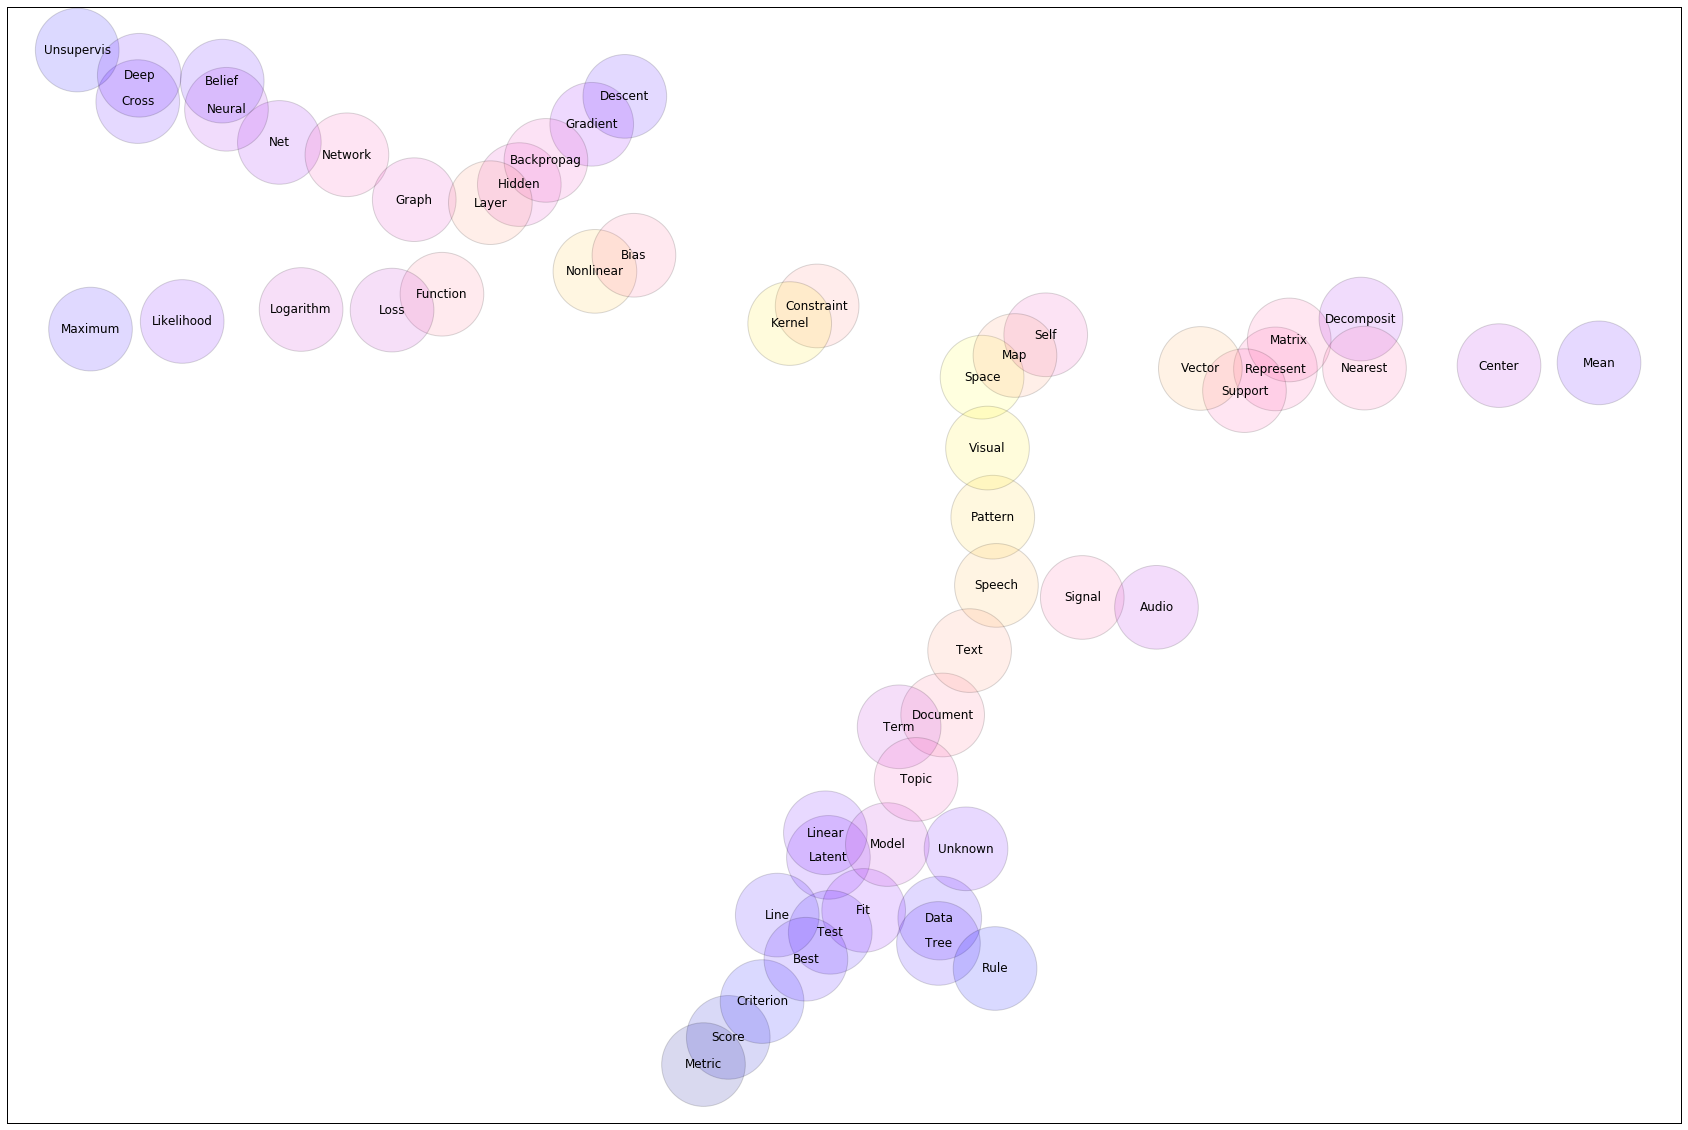

In [154]:
plot(G)